In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import contextily as ctx
from shapely.ops import split
import numpy as np
import folium
from folium import Popup

from scipy.stats import gmean

import matplotlib.pyplot as plt
import mapclassify

In [4]:
streets = gpd.read_file('../Road_Cleaned2/split_roads2.shp')

In [5]:
isochrone_bus=gpd.read_file('../Isochrones_700m/Isochrones_700m_Bus.geojson')
isochrone_subway=gpd.read_file('../Isochrones_700m/Isochrones_700m_Subway.geojson')

In [59]:
streets2 = streets.to_crs(epsg=3857)
interval = 500 #try 200, 300, 500? Potentially

def interpolate_points(line, interval):
    length = line.length
    points = [line.interpolate(distance) for distance in np.arange(0, length, interval)]
    start_point = Point(line.coords[0])
    end_point = Point(line.coords[-1])
    if start_point not in points:
        points.insert(0, start_point)
    if end_point not in points:
        points.append(end_point)
    return points


streets2['points'] = streets2['geometry'].apply(lambda geom: interpolate_points(geom, interval))

points_gdf = streets2.explode('points', ignore_index=True)
points_gdf = points_gdf.drop('geometry', axis=1)
points_gdf = points_gdf.rename(columns={'points': 'geometry'})


points_gdf = gpd.GeoDataFrame(points_gdf, geometry='geometry').set_crs(epsg=3857)
points_gdf

LINEARID           FULLNAME RTTYP  MTFCC  NEWID  \
0       1104485402227  State Rte 138 Spr     S  S1200      1   
1       1104485402227  State Rte 138 Spr     S  S1200      1   
2       1104485402227  State Rte 138 Spr     S  S1200      2   
3       1104485402227  State Rte 138 Spr     S  S1200      2   
4       1104485402227  State Rte 138 Spr     S  S1200      3   
...               ...                ...   ...    ...    ...   
193310   110342516783      State Rte 155     S  S1200  92258   
193311   110342524606   Brassie Ridge Ln     M  S1400  92259   
193312   110342524606   Brassie Ridge Ln     M  S1400  92259   
193313   110342519476          Summer Ln     M  S1400  92260   
193314   110342519476          Summer Ln     M  S1400  92260   

                                geometry  
0       POINT (-9390291.192 3965837.448)  
1       POINT (-9390556.578 3965892.867)  
2       POINT (-9390556.578 3965892.867)  
3       POINT (-9390644.186 3965915.436)  
4       POINT (-9390644.186 3965915.436)  
...                                  ...  
193310  POINT (-9370414.874 3978514.232)  
193311  POINT (-9370705.863 3980267.947)  
193312  POINT (-9371020.230 3980269.552)  
193313  POINT (-9368689.867 3978217.582)  
193314  POINT (-9368689.533 3978651.262)  

[193315 rows x 6 columns]

In [60]:
points_gdf2=points_gdf.to_crs(epsg=4326)
points_gdf2

LINEARID           FULLNAME RTTYP  MTFCC  NEWID  \
0       1104485402227  State Rte 138 Spr     S  S1200      1   
1       1104485402227  State Rte 138 Spr     S  S1200      1   
2       1104485402227  State Rte 138 Spr     S  S1200      2   
3       1104485402227  State Rte 138 Spr     S  S1200      2   
4       1104485402227  State Rte 138 Spr     S  S1200      3   
...               ...                ...   ...    ...    ...   
193310   110342516783      State Rte 155     S  S1200  92258   
193311   110342524606   Brassie Ridge Ln     M  S1400  92259   
193312   110342524606   Brassie Ridge Ln     M  S1400  92259   
193313   110342519476          Summer Ln     M  S1400  92260   
193314   110342519476          Summer Ln     M  S1400  92260   

                          geometry  
0       POINT (-84.35442 33.52979)  
1       POINT (-84.35680 33.53020)  
2       POINT (-84.35680 33.53020)  
3       POINT (-84.35759 33.53037)  
4       POINT (-84.35759 33.53037)  
...                            ...  
193310  POINT (-84.17587 33.62466)  
193311  POINT (-84.17848 33.63778)  
193312  POINT (-84.18131 33.63779)  
193313  POINT (-84.16037 33.62244)  
193314  POINT (-84.16037 33.62569)  

[193315 rows x 6 columns]

In [61]:
isochrone_bus.head()

stop_id  stop_code                      stop_name  \
0      355     906311    HOWELL MILL RD @ KIPLING DR   
1     9008     902632  N MAIN ST @ WINTHROPE PARK DR   
2     9012     902630                N MAIN ST @ 379   
3     9016     902631                N MAIN ST @ 301   
4     9020     900005      N MAIN ST @ PINE GROVE DR   

                           stop_desc   stop_lat   stop_lon  \
0  HOWELL MILL RD NW & KIPLING DR NW  33.813540 -84.414774   
1            0 MAIN & WINTHROPE PARK  34.089495 -84.294218   
2                               None  34.085826 -84.294957   
3                0 MAIN & PINE GROVE  34.083860 -84.294755   
4                0 MAIN & PINE GROVE  34.082292 -84.294607   

   wheelchair_boarding  route_type station_type  \
0                  1.0           3          Bus   
1                  1.0           3          Bus   
2                  1.0           3          Bus   
3                  1.0           3          Bus   
4                  1.0           3          Bus   

                                            geometry  
0  POLYGON ((33.81494 -84.41981, 33.81458 -84.419...  
1  POLYGON ((34.08912 -84.30002, 34.08876 -84.300...  
2  POLYGON ((34.08641 -84.29817, 34.08125 -84.296...  
3  POLYGON ((34.08182 -84.29906, 34.08164 -84.299...  
4  POLYGON ((34.08214 -84.30018, 34.08067 -84.299...

In [62]:
# Function to swap the x and y coordinates of a Polygon
def swap_xy(polygon):
    # Extract the exterior coordinates and swap x (longitude) and y (latitude)
    new_coords = [(y, x) for x, y in polygon.exterior.coords]
    return Polygon(new_coords)

# Apply the swap_xy function to each geometry in the isochrone_bus GeoDataFrame
isochrone_bus2=isochrone_bus.copy()
isochrone_bus2['geometry'] = isochrone_bus2['geometry'].apply(swap_xy)

In [63]:
joined_gdf = gpd.sjoin(points_gdf2, isochrone_bus2, how='left', predicate='intersects')
intersection_count = joined_gdf.groupby(joined_gdf.index)['index_right'].count()

points_gdf3 = points_gdf2.copy()
points_gdf3['intersection_count'] = points_gdf3.index.map(intersection_count).fillna(0)

In [64]:
points_gdf3

LINEARID           FULLNAME RTTYP  MTFCC  NEWID  \
0       1104485402227  State Rte 138 Spr     S  S1200      1   
1       1104485402227  State Rte 138 Spr     S  S1200      1   
2       1104485402227  State Rte 138 Spr     S  S1200      2   
3       1104485402227  State Rte 138 Spr     S  S1200      2   
4       1104485402227  State Rte 138 Spr     S  S1200      3   
...               ...                ...   ...    ...    ...   
193310   110342516783      State Rte 155     S  S1200  92258   
193311   110342524606   Brassie Ridge Ln     M  S1400  92259   
193312   110342524606   Brassie Ridge Ln     M  S1400  92259   
193313   110342519476          Summer Ln     M  S1400  92260   
193314   110342519476          Summer Ln     M  S1400  92260   

                          geometry  intersection_count  
0       POINT (-84.35442 33.52979)                   6  
1       POINT (-84.35680 33.53020)                   5  
2       POINT (-84.35680 33.53020)                   5  
3       POINT (-84.35759 33.53037)                   4  
4       POINT (-84.35759 33.53037)                   4  
...                            ...                 ...  
193310  POINT (-84.17587 33.62466)                   0  
193311  POINT (-84.17848 33.63778)                   0  
193312  POINT (-84.18131 33.63779)                   0  
193313  POINT (-84.16037 33.62244)                   0  
193314  POINT (-84.16037 33.62569)                   0  

[193315 rows x 7 columns]

<span style="color: #FFDB58">From some points, up to 60 bus stops can be reached within a 700-meter walking distance! (I think it's true)</span>

In [65]:
unique_values = points_gdf3['intersection_count'].unique()
print(unique_values)

[ 6  5  4  7  8 11 10  0  3  2  1  9 13 14 12 16 15 17 18 20 23 22 19 21
 40 24 30 34 35 31 28 27 26 25 33 32 29 38 36 39 37 52 48 41 46 54 53 55
 60 57 59 44 42 49 47 51 56 45 43 50 58]


In [66]:
bus_stops_df = pd.read_csv('../Stops_Cleaned/bus_stops.csv')
subway_stops_df = pd.read_csv('../Stops_Cleaned/subway_stops.csv')

bus_stops_gdf = gpd.GeoDataFrame(bus_stops_df, geometry=gpd.points_from_xy(bus_stops_df.stop_lon, bus_stops_df.stop_lat), crs="EPSG: 4326")
subway_stops_gdf = gpd.GeoDataFrame(subway_stops_df, geometry=gpd.points_from_xy(subway_stops_df.stop_lon, subway_stops_df.stop_lat), crs="EPSG: 4326")

### 기댓값 계산

어떤 Street 경로상에서 도달 할 수 있는 대중교통 정류장 개수의 기댓값은?  
  
각 포인트당 도달 가능한 정류장의 개수의 합 / 포인트의 개수

<span style="color: #FFDB58"> 1007 Idea </span>  
기하 평균 사용하기  
모든 값을 곱한 후  
값의 개수 제곱근을 취한다


In [67]:
grouped_df = points_gdf3.groupby('NEWID').agg({
    'FULLNAME': 'first',
    'RTTYP': 'first',
    'MTFCC': 'first',
    'LINEARID': 'first',
    'intersection_count': lambda x: gmean(x),
}).reset_index()

In [68]:
grouped_df

NEWID           FULLNAME RTTYP  MTFCC       LINEARID  \
0          1  State Rte 138 Spr     S  S1200  1104485402227   
1          2  State Rte 138 Spr     S  S1200  1104485402227   
2          3  State Rte 138 Spr     S  S1200  1104485402227   
3          4  State Rte 138 Spr     S  S1200  1104485402227   
4          5  State Rte 138 Spr     S  S1200  1104485402227   
...      ...                ...   ...    ...            ...   
92255  92256     County Line Rd     M  S1400   110342523635   
92256  92257     County Line Rd     M  S1400   110342523635   
92257  92258      State Rte 155     S  S1200   110342516783   
92258  92259   Brassie Ridge Ln     M  S1400   110342524606   
92259  92260          Summer Ln     M  S1400   110342519476   

       intersection_count  
0                5.477226  
1                4.472136  
2                5.291503  
3                6.480741  
4                6.480741  
...                   ...  
92255            0.000000  
92256            0.000000  
92257            0.000000  
92258            0.000000  
92259            0.000000  

[92260 rows x 6 columns]

In [69]:
streets_updated = streets.merge(grouped_df[['NEWID', 'intersection_count']], on='NEWID', how='left')
streets_updated = streets_updated.rename(columns={'intersection_count': 'stops_mean'})
streets_updated

LINEARID           FULLNAME RTTYP  MTFCC  NEWID  \
0      1104485402227  State Rte 138 Spr     S  S1200      1   
1      1104485402227  State Rte 138 Spr     S  S1200      2   
2      1104485402227  State Rte 138 Spr     S  S1200      3   
3      1104485402227  State Rte 138 Spr     S  S1200      4   
4      1104485402227  State Rte 138 Spr     S  S1200      5   
...              ...                ...   ...    ...    ...   
92255   110342523635     County Line Rd     M  S1400  92256   
92256   110342523635     County Line Rd     M  S1400  92257   
92257   110342516783      State Rte 155     S  S1200  92258   
92258   110342524606   Brassie Ridge Ln     M  S1400  92259   
92259   110342519476          Summer Ln     M  S1400  92260   

                                                geometry  stops_mean  
0      LINESTRING (-84.35442 33.52979, -84.35680 33.5...    5.477226  
1      LINESTRING (-84.35680 33.53020, -84.35759 33.5...    4.472136  
2      LINESTRING (-84.35759 33.53037, -84.35851 33.5...    5.291503  
3      LINESTRING (-84.36041 33.53121, -84.36195 33.5...    6.480741  
4      LINESTRING (-84.36195 33.53189, -84.36274 33.5...    6.480741  
...                                                  ...         ...  
92255  LINESTRING (-84.18414 33.64616, -84.18406 33.6...    0.000000  
92256  LINESTRING (-84.18412 33.64300, -84.18400 33.6...    0.000000  
92257  LINESTRING (-84.18158 33.62917, -84.18154 33.6...    0.000000  
92258  LINESTRING (-84.17848 33.63778, -84.17926 33.6...    0.000000  
92259  LINESTRING (-84.16037 33.62244, -84.16039 33.6...    0.000000  

[92260 rows x 7 columns]

In [70]:
# GeoJSON으로 저장
import os
folder_path = 'Isochrone_Busstops_Result'
file_path_geojson = os.path.join(folder_path, '500m_Busstops_Result.geojson')
streets_updated.to_file(file_path_geojson, driver='GeoJSON')

In [2]:
street50=gpd.read_file("Isochrone_Busstops_Result/50m_Busstops_Result.geojson")
street100=gpd.read_file("Isochrone_Busstops_Result/100m_Busstops_Result.geojson")
street200=gpd.read_file("Isochrone_Busstops_Result/200m_Busstops_Result.geojson")
street300=gpd.read_file("Isochrone_Busstops_Result/300m_Busstops_Result.geojson")
street500=gpd.read_file("Isochrone_Busstops_Result/500m_Busstops_Result.geojson")

In [72]:
street50.head()

LINEARID           FULLNAME RTTYP  MTFCC  NEWID  stops_mean  \
0  1104485402227  State Rte 138 Spr     S  S1200      1    5.695450   
1  1104485402227  State Rte 138 Spr     S  S1200      2    4.641589   
2  1104485402227  State Rte 138 Spr     S  S1200      3    7.363543   
3  1104485402227  State Rte 138 Spr     S  S1200      4    6.381606   
4  1104485402227  State Rte 138 Spr     S  S1200      5    6.187862   

                                            geometry  
0  LINESTRING (-84.35442 33.52979, -84.35680 33.5...  
1  LINESTRING (-84.35680 33.53020, -84.35759 33.5...  
2  LINESTRING (-84.35759 33.53037, -84.35851 33.5...  
3  LINESTRING (-84.36041 33.53121, -84.36195 33.5...  
4  LINESTRING (-84.36195 33.53189, -84.36274 33.5...

In [73]:
street100.head()

LINEARID           FULLNAME RTTYP  MTFCC  NEWID  stops_mean  \
0  1104485402227  State Rte 138 Spr     S  S1200      1    5.732657   
1  1104485402227  State Rte 138 Spr     S  S1200      2    4.472136   
2  1104485402227  State Rte 138 Spr     S  S1200      3    7.068052   
3  1104485402227  State Rte 138 Spr     S  S1200      4    6.316360   
4  1104485402227  State Rte 138 Spr     S  S1200      5    6.316360   

                                            geometry  
0  LINESTRING (-84.35442 33.52979, -84.35680 33.5...  
1  LINESTRING (-84.35680 33.53020, -84.35759 33.5...  
2  LINESTRING (-84.35759 33.53037, -84.35851 33.5...  
3  LINESTRING (-84.36041 33.53121, -84.36195 33.5...  
4  LINESTRING (-84.36195 33.53189, -84.36274 33.5...

In [74]:
street200.head()

LINEARID           FULLNAME RTTYP  MTFCC  NEWID  stops_mean  \
0  1104485402227  State Rte 138 Spr     S  S1200      1    5.646216   
1  1104485402227  State Rte 138 Spr     S  S1200      2    4.472136   
2  1104485402227  State Rte 138 Spr     S  S1200      3    6.542133   
3  1104485402227  State Rte 138 Spr     S  S1200      4    6.480741   
4  1104485402227  State Rte 138 Spr     S  S1200      5    6.480741   

                                            geometry  
0  LINESTRING (-84.35442 33.52979, -84.35680 33.5...  
1  LINESTRING (-84.35680 33.53020, -84.35759 33.5...  
2  LINESTRING (-84.35759 33.53037, -84.35851 33.5...  
3  LINESTRING (-84.36041 33.53121, -84.36195 33.5...  
4  LINESTRING (-84.36195 33.53189, -84.36274 33.5...

In [75]:
street300.head()

LINEARID           FULLNAME RTTYP  MTFCC  NEWID  stops_mean  \
0  1104485402227  State Rte 138 Spr     S  S1200      1    5.477226   
1  1104485402227  State Rte 138 Spr     S  S1200      2    4.472136   
2  1104485402227  State Rte 138 Spr     S  S1200      3    6.316360   
3  1104485402227  State Rte 138 Spr     S  S1200      4    6.480741   
4  1104485402227  State Rte 138 Spr     S  S1200      5    6.480741   

                                            geometry  
0  LINESTRING (-84.35442 33.52979, -84.35680 33.5...  
1  LINESTRING (-84.35680 33.53020, -84.35759 33.5...  
2  LINESTRING (-84.35759 33.53037, -84.35851 33.5...  
3  LINESTRING (-84.36041 33.53121, -84.36195 33.5...  
4  LINESTRING (-84.36195 33.53189, -84.36274 33.5...

In [76]:
street500.head()

LINEARID           FULLNAME RTTYP  MTFCC  NEWID  stops_mean  \
0  1104485402227  State Rte 138 Spr     S  S1200      1    5.477226   
1  1104485402227  State Rte 138 Spr     S  S1200      2    4.472136   
2  1104485402227  State Rte 138 Spr     S  S1200      3    5.291503   
3  1104485402227  State Rte 138 Spr     S  S1200      4    6.480741   
4  1104485402227  State Rte 138 Spr     S  S1200      5    6.480741   

                                            geometry  
0  LINESTRING (-84.35442 33.52979, -84.35680 33.5...  
1  LINESTRING (-84.35680 33.53020, -84.35759 33.5...  
2  LINESTRING (-84.35759 33.53037, -84.35851 33.5...  
3  LINESTRING (-84.36041 33.53121, -84.36195 33.5...  
4  LINESTRING (-84.36195 33.53189, -84.36274 33.5...

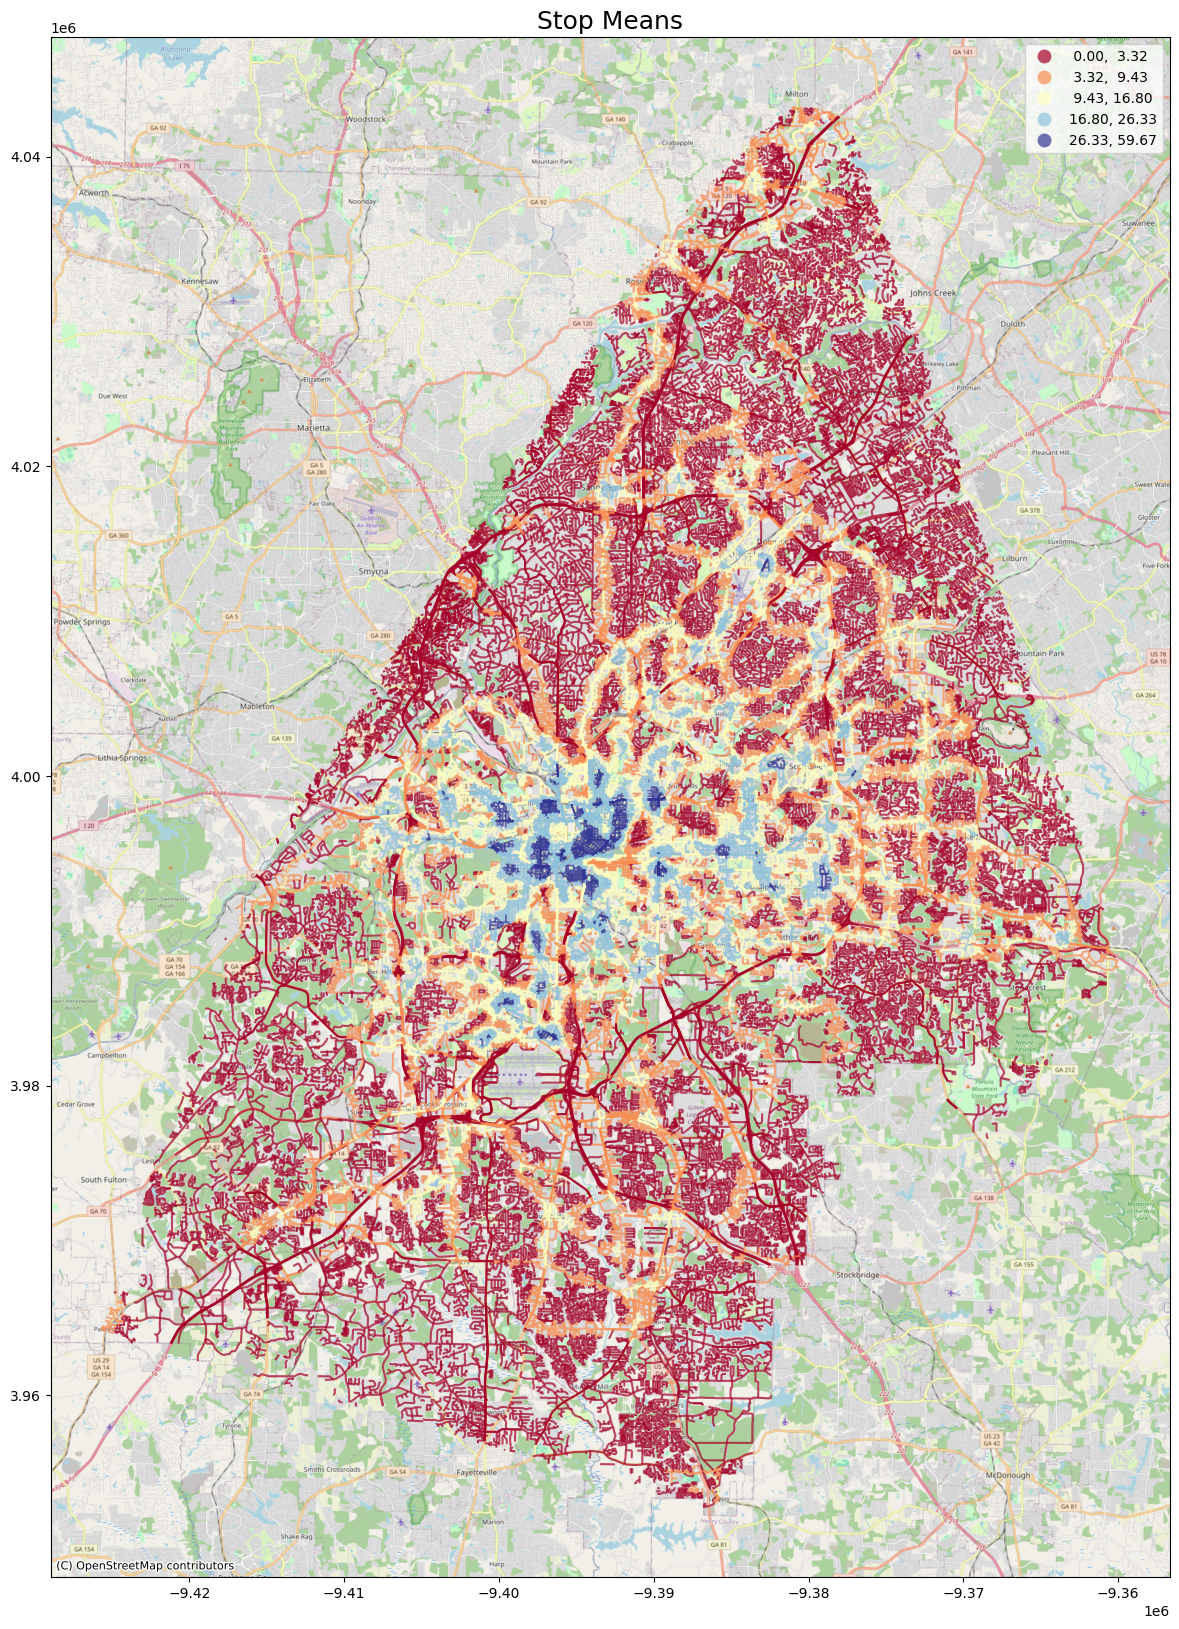

In [167]:
classifier = mapclassify.NaturalBreaks(street50['stops_mean'], k=5)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plotting the street geometries, with colors based on the stops_mean column, natural breaks, and transparency
street50.to_crs(epsg=3857).plot(column='stops_mean', 
                                cmap='RdYlBu', 
                                legend=True, 
                                ax=ax, 
                                scheme='NaturalBreaks', 
                                classification_kwds={'k': 5}, 
                                alpha=0.7)

# Add the basemap (e.g., OpenStreetMap) to the plot
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Add a title and show the plot
ax.set_title('Stop Means', fontsize=18)
plt.savefig('Street50_plot.png', dpi=300)
plt.show()

### Sensitivity Analysis

In [3]:
merged_df = street50[['LINEARID', 'stops_mean']].rename(columns={'stops_mean': 'stops_mean_50'}).merge(
    street100[['LINEARID', 'stops_mean']].rename(columns={'stops_mean': 'stops_mean_100'}), on='LINEARID')

In [4]:
merged_df

LINEARID  stops_mean_50  stops_mean_100
0        1104485402227        5.69545        5.732657
1        1104485402227        5.69545        4.472136
2        1104485402227        5.69545        7.068052
3        1104485402227        5.69545        6.316360
4        1104485402227        5.69545        6.316360
...                ...            ...             ...
1168621   110342523635        0.00000        0.000000
1168622   110342523635        0.00000        0.000000
1168623   110342516783        0.00000        0.000000
1168624   110342524606        0.00000        0.000000
1168625   110342519476        0.00000        0.000000

[1168626 rows x 3 columns]

In [5]:
merged_df = merged_df[['LINEARID', 'stops_mean_50', 'stops_mean_100']].merge(street200[['LINEARID', 'stops_mean']].rename(columns={'stops_mean': 'stops_mean_200'}), on='LINEARID')

Something went wrong with 300m, 500m data... Maybe my laptop cannot handle. Gonna Skip it.

### ANOVA

In [6]:
from scipy.stats import f_oneway

anova_results = f_oneway(
    merged_df['stops_mean_50'],
    merged_df['stops_mean_100'],
    merged_df['stops_mean_200'],
)

print(f"F-statistic: {anova_results.statistic}, P-value: {anova_results.pvalue}")

F-statistic: 2.9061606099929698, P-value: 0.05468528789543891


### Relative error

In [8]:
merged_df['diff_50_100'] = merged_df['stops_mean_100'] - merged_df['stops_mean_50']
merged_df['diff_50_200'] = merged_df['stops_mean_200'] - merged_df['stops_mean_50']

merged_df[['diff_50_100', 'diff_50_200']].describe()

diff_50_100   diff_50_200
count  7.700087e+07  7.700087e+07
mean  -1.634888e-03  1.946464e-03
std    1.013383e+01  1.012272e+01
min   -5.966480e+01 -5.966480e+01
25%   -5.711141e+00 -5.695560e+00
50%    0.000000e+00  0.000000e+00
75%    5.717443e+00  5.707405e+00
max    5.949790e+01  5.949790e+01